In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cleaning data code

In [ ]:
import pickle
import os
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import csv
import matplotlib.pyplot as plt

In [ ]:
PATH = "/content/drive/MyDrive/Buildings project3"  # path pointing to the dirty_data directory
BLACKLISTED_VARIABLES = [] # add here variables you wish to exclude
ALL_MEASURES = ['temperature', 'humidity', 'co2', 'pir_cnt', 'pressure']  # add here variables you wish to include
SEED = 359150
CONTLEN = 60  # minimum length of continuous sections considered

In [ ]:
sensorMinValDict = {
 'temperature':  0.0,
 'humidity':     0.0,
 'pressure':     950.0,
 'co2':     300,  # Minimum valid CO2 reading in ppm
 'pir_cnt': 0
}

In [ ]:
sensorMaxValDict = {
 'temperature':  40.0,
 'humidity':     99.0,
 'pressure':     1200.0,
 'co2':     5000,  # Maximum valid CO2 reading in ppm
 'pir_cnt': 12
}

In [ ]:
def find_hard_sections(data):
    """
    Finds sections in the data in which CO2 values change notably. Returns a random subset of 30% of these
    :param data: dict
    :return: tuple of dicts
    """
    maxs = list()
    stds = list()
    for room in data.keys():
        for frame in data[room]:
            stds.append(frame.co2.std())
            maxs.append(frame.co2.diff().abs().max())

    df = pd.DataFrame(np.column_stack((stds, maxs)))

    stdlim = int(df[0].quantile(0.80))
    difflim = int(df[1].quantile(0.80))

    np.random.seed(SEED)
    difficult_frames = dict()
    for room in data.keys():
        roomframes = list()
        for i, frame in enumerate(data[room]):
            if (frame.co2.std() > stdlim) or (frame.co2.diff().abs().max() > difflim):
                if np.random.rand() < 0.30:
                    roomframes.append(frame)
                    del data[room][i]
            difficult_frames[room] = roomframes

    return data, difficult_frames


In [ ]:
def series_to_supervised(frame, xhistory, yfut, inputvars, outputvars, add_ind=None):
    # Form the train_x frame:
    xframe = []
    for i in np.arange(xhistory - 1, -1, -1):
        train_x = frame.shift(periods=i)
        train_x = train_x[inputvars]  # Select the columns to be included.
        train_x.columns = [c + '_{}'.format(i) for c in train_x.columns]
        xframe.append(train_x)
    xframe = pd.concat(xframe, axis=1)

    # Form the train_y frame:
    yframe = frame.shift(periods=-yfut)
    yframe = yframe[outputvars]  # Select the columns to be included.
    yframe.columns = [outputvars + '_y']

    # Merge the x and y frames
    xy_frame = pd.concat([xframe, yframe], axis=1).dropna()

    # add frame id if provided:
    if add_ind is not None:
        xy_frame['frame_id'] = add_ind
    return xy_frame

In [ ]:
def localize_utc_timestamps(ts):
    """
    Localize utc times to our time
    :param ts: pandas Series
    :return: pandas Series
    """
    return ts.apply(lambda x: pytz.timezone('UTC').localize(x).astimezone(pytz.timezone('Europe/Helsinki')))


def create_dirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
class ScottDataCleaner:
    def __init__(self, root_dir):
        self.root_dir = root_dir

    def get_rooms(self):
        """Returns list of rooms"""
        return os.listdir(self.root_dir)

    def path_to_room(self, room):
        """Returns path to room directory"""
        return self.root_dir + os.sep + room

    def path_to_cleaned_data(self):
        return os.path.abspath(os.path.join(self.root_dir, '..', 'cleaned_data'))

    def cont_sections_data(self, contlen):
        """Read in data that is split into continuous sections"""
        filename = self.path_to_cleaned_data() + os.sep + 'continuous_sections_' + str(contlen) + '.pickle'
        return pickle.load(open(filename, 'rb'))

    def dirty_data_to_pickle_room(self, room):
        """Convert dirty data to pickle for a single room"""

        # collects files to a list
        path = self.path_to_room(room)
        files = os.listdir(path)
        files = [f for f in files if f.endswith('csv')]
        thp = list()

        # loop through files
        for file in files:
            # read in file, drop sensor id and blacklisted cols, convert timestamp
            dat = pd.read_csv(path + os.sep + file)
            dat = dat.drop('nodeid', axis=1)
            if len(BLACKLISTED_VARIABLES) > 0:
                try:
                    dat = dat.drop(BLACKLISTED_VARIABLES, axis=1)
                except KeyError:
                    pass
            dat.devicetimestamp = dat.devicetimestamp.apply(datetime.utcfromtimestamp)

            # append thp to thp list
            thp.append(dat)

        # concatenate different sensors' data, sort by timestamp and save the list as a dict with sensor name as key
        thp = pd.concat(thp, sort=False)
        thp = thp.sort_values('devicetimestamp')
        thp = thp.reset_index(drop=True)
        # roomdats['thp'] = thp

        filename = "{}/{}_dirty_data.pickle".format(path, room)
        with open(filename, 'wb') as fp:
            pickle.dump(thp, fp)

    def dirty_data_to_pickles(self):
        """Convert dirty data to pickles to all the rooms"""

        # loop through rooms
        for room in self.get_rooms():
            self.dirty_data_to_pickle_room(room)

    @staticmethod
    def interpolate_single_missing(df):
        """If there is a value for single minute missing, interpolate it with mean of previous and next value.
        Assumes that the frame is indexed with 1min frequency"""
        df = df.copy()
        inds = np.where(df.isna())[0]
        inds = [i for i in inds if i + 1 not in inds and i - 1 not in inds]
        for ind in inds:
            df.iloc[ind] = np.mean([df.iloc[ind - 1], df.iloc[ind + 1]]).round(2)
        return df

    def aggregate_room(self, room):
        """
        Aggregate data from different sensors in the given room
        :param room: string
        :return: -
        """

        # read in combined data from different sensors
        path = self.path_to_room(room)
        filename = "{}/{}_dirty_data.pickle".format(path, room)
        dat = pickle.load(open(filename, 'rb'))

        # resample with median, localize timestamps and fill in each 1min gaps for CO2
        dat = dat.set_index('devicetimestamp')
        df = dat.resample('1min').apply(np.nanmedian)
        df = df.reset_index()
        df.devicetimestamp = localize_utc_timestamps(df.devicetimestamp)
        df = df.set_index('devicetimestamp')
        df['co2'] = self.interpolate_single_missing(df['co2'])

        # reindex to having each minute available
        start = pd.to_datetime(datetime.strptime('2019-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'))
        newind = pd.date_range(start, periods=60 * 24 * 365, freq='1min', tz=pytz.timezone('Europe/Helsinki'))
        df = df.reindex(newind)

        # save results
        filename = "{}/{}_aggregate_data.pickle".format(path, room)
        with open(filename, 'wb') as fp:
            pickle.dump(df, fp)

    def aggregate(self):
        """Loop through all the rooms for aggregation"""
        for room in self.get_rooms():
            self.aggregate_room(room)

    def continuous_sections_room(self, room, contlen):
        """
        Find continuous sections of len contlen for each room and drop clear outliers
        :param room: string
        :param contlen: int
        :return: list
        """
        # read in data and drop missing values
        path = self.path_to_room(room)
        filename = "{}/{}_aggregate_data.pickle".format(path, room)
        dat = pickle.load(open(filename, 'rb'))
        dat = dat.dropna()

        # remove outliers
        for col in dat.columns:
            dat = dat[(dat[col] >= sensorMinValDict[col]) & (dat[col] <= sensorMaxValDict[col])]

        # find indeces where the gap is longer than a minute
        dat.index.name = 'devicetimestamp'
        dat = dat.reset_index()
        inds = np.where(dat.devicetimestamp.diff() != np.timedelta64(1, 'm'))[0]
        dat = dat.set_index('devicetimestamp')

        # find continuous sections of at least length contlen
        cont_sections = list()
        for i, ind in enumerate(inds[:-1]):
            aux = dat.iloc[ind:inds[i+1]]
            if len(aux) >= contlen:
                cont_sections.append(aux)
        aux = dat.iloc[inds[-1]:]
        if len(aux) >= contlen:
            cont_sections.append(aux)
        return cont_sections

    def split_continuous_sections(self, contlen):
        """
        Split data from all rooms into continuous sections, save results on disk
        :param contlen: int
        :return: -
        """
        css = dict()
        for room in self.get_rooms():
            cs = self.continuous_sections_room(room, contlen)
            css[room] = cs

        path = os.path.abspath(os.path.join(self.root_dir, '..', 'cleaned_data'))
        create_dirs(path)
        filename = path + os.sep + 'continuous_sections_' + str(contlen) + '.pickle'
        with open(filename, 'wb') as fp:
            pickle.dump(css, fp)

    def get_data_in_supervised(self, xhistory, yfut, predictors, response, contlen):
        """
        Transforms the data that is split into continuous sections to the form required by time series future value
        estimation
        :param xhistory: int, length of history to use (1=only current value, 2=current and previous etc)
        :param yfut: int, how far into the future to predict (1=1mins from now, 2=2mins from now etc)
        :param predictors: list of strings, variables to use as predictors
        :param response: string, variable to predict
        :param contlen: int, the minimum length of continuous sections to use
        :return: dict
        """
        data = self.cont_sections_data(contlen)

        supervised_frames = dict()
        for room in data.keys():
            sup_frames_room = list()
            for frame in data[room]:
                sup_frames_room.append(series_to_supervised(frame, xhistory, yfut, predictors, response))
            supervised_frames[room] = sup_frames_room
        return supervised_frames

    def extract_train_test_data(self):
        """Splits the continuous_sections data into training and testing or returns train and test data if they are
        already splitted"""
        path = os.path.join(self.root_dir, '/content/drive/MyDrive/Buildings project3')
        traindata = path + '/continuous_sections_{}_train.pickle'.format(CONTLEN)
        testdata = path + '/continuous_sections_{}_test.pickle'.format(CONTLEN)

        if os.path.exists(traindata):
            train = pickle.load(open(traindata, 'rb'))
            test = pickle.load(open(testdata, 'rb'))
        else:
            print("Train/test data did not exist, calculating...")

            data = self.cont_sections_data(CONTLEN)
            train, test = find_hard_sections(data)

            print("Saving results...")
            with open(traindata, 'wb') as fp:
                pickle.dump(train, fp)
            with open(testdata, 'wb') as fp:
                pickle.dump(test, fp)
            print("Done! Returning results")
        return train, test

In [ ]:
if __name__ == '__main__':
    cleaner = ScottDataCleaner(PATH)

    # convert to pickle files
    s = datetime.now()
    cleaner.dirty_data_to_pickles()
    s1 = datetime.now()
    print(s1-s)

    # aggregate room data
    cleaner.aggregate()
    e1 = datetime.now()
    print(e1 - s1)
    print(e1 - s)

    # split into continuous sections of at least CONTLEN minutes
    cleaner.split_continuous_sections(CONTLEN)
    e2 = datetime.now()
    print(e2 - e1)
    print(e2 - s)

    # uncomment this to split continuous sections data into train and test
    train, test = cleaner.extract_train_test_data()  # this needs to be run once

0:00:42.973328
0:01:26.628337
0:02:09.601665
0:00:04.595584
0:02:14.197249
Train/test data did not exist, calculating...
Saving results...
Done! Returning results


In [ ]:
with open('/content/drive/MyDrive/Buildings project3/continuous_sections_60_train.pickle', 'rb') as f:
    data_train = pickle.load(f)

In [ ]:
dataframes_list_train = list(data_train.values())
dataframes_list_train

[[                           temperature  humidity  pressure    co2  pir_cnt
  devicetimestamp                                                           
  2019-01-09 16:27:00+02:00       20.950    15.050   1012.55  575.0      5.0
  2019-01-09 16:28:00+02:00       20.955    15.035   1012.50  575.0      4.0
  2019-01-09 16:29:00+02:00       21.370    15.040   1012.40  575.0      7.0
  2019-01-09 16:30:00+02:00       20.945    15.035   1012.50  575.0      7.0
  2019-01-09 16:31:00+02:00       20.955    15.045   1012.50  575.0      1.0
  ...                                ...       ...       ...    ...      ...
  2019-01-10 08:17:00+02:00       20.240    12.430   1011.70  443.0      0.0
  2019-01-10 08:18:00+02:00       20.230    12.340   1011.90  444.0      0.0
  2019-01-10 08:19:00+02:00       20.220    12.340   1011.80  443.0      0.0
  2019-01-10 08:20:00+02:00       20.300    12.340   1011.70  444.0      0.0
  2019-01-10 08:21:00+02:00       20.255    12.070   1011.90  443.0      0.0

In [ ]:
with open('/content/drive/MyDrive/Buildings project3/continuous_sections_60_test.pickle', 'rb') as f:
    data_test = pickle.load(f)
dataframes_list_test = list(data_test.values())

# Merging train and test datas

Room 00

In [ ]:
obj_train = pd.read_pickle(r'/content/drive/MyDrive/Buildings project3/continuous_sections_60_train.pickle')

# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_train["room00"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_train["room00"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_train_room00 = pd.concat(obj_train["room00"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_train_room00.reset_index(inplace=True, drop=True)

obj_test = pd.read_pickle(r'/content/drive/MyDrive/Buildings project3/continuous_sections_60_test.pickle')

# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_test["room00"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_test["room00"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_test_room00 = pd.concat(obj_test["room00"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_test_room00.reset_index(inplace=True, drop=True)

# Объединение данных по столбцу devicetimestamp
combined_data = pd.concat([combined_data_train_room00, combined_data_test_room00])

# Сортировка по столбцу devicetimestamp
combined_data.sort_values('devicetimestamp', inplace=True)

# Заполнение пропущенных значений методом ffill
combined_data.ffill(inplace=True)

# Путь для сохранения объединенного файла
path = "/content/drive/MyDrive/Buildings project3/Cleaned data/Room00.csv"

# Сохранение объединенного документа
combined_data.to_csv(path, index=False)

Room 01

In [ ]:
# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_train["room01"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_train["room01"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_train_room01 = pd.concat(obj_train["room01"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_train_room01.reset_index(inplace=True, drop=True)

# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_test["room01"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_test["room01"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_test_room01 = pd.concat(obj_test["room01"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_test_room01.reset_index(inplace=True, drop=True)

# Объединение данных по столбцу devicetimestamp
combined_data = pd.concat([combined_data_train_room01, combined_data_test_room01])

# Сортировка по столбцу devicetimestamp
combined_data.sort_values('devicetimestamp', inplace=True)

# Заполнение пропущенных значений методом ffill
combined_data.ffill(inplace=True)

# Путь для сохранения объединенного файла
path = "/content/drive/MyDrive/Buildings project3/Cleaned data/Room01.csv"

# Сохранение объединенного документа
combined_data.to_csv(path, index=False)

Room02

In [ ]:
# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_train["room02"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_train["room02"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_train_room02 = pd.concat(obj_train["room02"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_train_room02.reset_index(inplace=True, drop=True)

# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_test["room02"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_test["room02"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_test_room02 = pd.concat(obj_test["room02"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_test_room02.reset_index(inplace=True, drop=True)

# Объединение данных по столбцу devicetimestamp
combined_data = pd.concat([combined_data_train_room02, combined_data_test_room02])

# Сортировка по столбцу devicetimestamp
combined_data.sort_values('devicetimestamp', inplace=True)

# Заполнение пропущенных значений методом ffill
combined_data.ffill(inplace=True)

# Путь для сохранения объединенного файла
path = "/content/drive/MyDrive/Buildings project3/Cleaned data/Room02.csv"

# Сохранение объединенного документа
combined_data.to_csv(path, index=False)

Room03

In [ ]:
# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_train["room03"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_train["room03"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_train_room03 = pd.concat(obj_train["room03"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_train_room03.reset_index(inplace=True, drop=True)

# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_test["room03"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_test["room03"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_test_room03 = pd.concat(obj_test["room03"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_test_room03.reset_index(inplace=True, drop=True)

# Объединение данных по столбцу devicetimestamp
combined_data = pd.concat([combined_data_train_room03, combined_data_test_room03])

# Сортировка по столбцу devicetimestamp
combined_data.sort_values('devicetimestamp', inplace=True)

# Заполнение пропущенных значений методом ffill
combined_data.ffill(inplace=True)

# Путь для сохранения объединенного файла
path = "/content/drive/MyDrive/Buildings project3/Cleaned data/Room03.csv"

# Сохранение объединенного документа
combined_data.to_csv(path, index=False)

Room04

In [ ]:
# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_train["room04"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_train["room04"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_train_room04 = pd.concat(obj_train["room04"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_train_room04.reset_index(inplace=True, drop=True)

# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_test["room04"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_test["room04"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_test_room04 = pd.concat(obj_test["room04"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_test_room04.reset_index(inplace=True, drop=True)

# Объединение данных по столбцу devicetimestamp
combined_data = pd.concat([combined_data_train_room04, combined_data_test_room04])

# Сортировка по столбцу devicetimestamp
combined_data.sort_values('devicetimestamp', inplace=True)

# Заполнение пропущенных значений методом ffill
combined_data.ffill(inplace=True)

# Путь для сохранения объединенного файла
path = "/content/drive/MyDrive/Buildings project3/Cleaned data/Room04.csv"

# Сохранение объединенного документа
combined_data.to_csv(path, index=False)

Room05

In [ ]:
# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_train["room05"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_train["room05"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_train_room05 = pd.concat(obj_train["room05"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_train_room05.reset_index(inplace=True, drop=True)

# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_test["room05"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_test["room05"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_test_room05 = pd.concat(obj_test["room05"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_test_room05.reset_index(inplace=True, drop=True)

# Объединение данных по столбцу devicetimestamp
combined_data = pd.concat([combined_data_train_room05, combined_data_test_room05])

# Сортировка по столбцу devicetimestamp
combined_data.sort_values('devicetimestamp', inplace=True)

# Заполнение пропущенных значений методом ffill
combined_data.ffill(inplace=True)

# Путь для сохранения объединенного файла
path = "/content/drive/MyDrive/Buildings project3/Cleaned data/Room05.csv"

# Сохранение объединенного документа
combined_data.to_csv(path, index=False)

Room06

In [ ]:
# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_train["room06"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_train["room06"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_train_room06 = pd.concat(obj_train["room06"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_train_room06.reset_index(inplace=True, drop=True)

# Assuming data_frames is a list containing your individual DataFrames
for i, df in enumerate(obj_test["room06"]):
    # Resetting the index and creating a new column 'devicetimestamp'
    obj_test["room06"][i] = df.reset_index()

# Concatenating the individual DataFrames along the rows (axis=0)
combined_data_test_room06 = pd.concat(obj_test["room06"])

# Resetting the index to have a continuous index for the combined DataFrame
combined_data_test_room06.reset_index(inplace=True, drop=True)

# Объединение данных по столбцу devicetimestamp
combined_data = pd.concat([combined_data_train_room06, combined_data_test_room06])

# Сортировка по столбцу devicetimestamp
combined_data.sort_values('devicetimestamp', inplace=True)

# Заполнение пропущенных значений методом ffill
combined_data.ffill(inplace=True)

# Путь для сохранения объединенного файла
path = "/content/drive/MyDrive/Buildings project3/Cleaned data/Room06.csv"

# Сохранение объединенного документа
combined_data.to_csv(path, index=False)

combined_data

,devicetimestamp,temperature,humidity,pressure,co2,pir_cnt
0,2019-01-23 11:09:00+02:00,22.380,9.170,1006.80,583.0,10.0
1,2019-01-23 11:10:00+02:00,22.370,9.120,1006.80,579.0,7.0
2,2019-01-23 11:11:00+02:00,21.900,8.410,1006.90,579.0,5.5
3,2019-01-23 11:12:00+02:00,21.490,9.070,1006.80,580.0,12.0
4,2019-01-23 11:13:00+02:00,21.960,8.530,1007.05,583.0,8.0
...,...,...,...,...,...,...
387761,2019-12-31 23:55:00+02:00,20.465,17.390,998.90,396.0,0.0
387762,2019-12-31 23:56:00+02:00,20.460,17.390,998.90,396.0,0.0
387763,2019-12-31 23:57:00+02:00,20.470,17.395,998.90,395.0,0.0
387764,2019-12-31 23:58:00+02:00,20.470,17.400,998.95,395.0,0.0


# Adding new features

Room00

In [ ]:
# Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/Buildings project3/Cleaned data/Room00.csv")  # Замените путь на ваш файл

# Преобразование devicetimestamp в формат datetime
data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], utc=True)

# Количество временных шагов, на которые вы хотите отложить признаки
lags = 3

# Создание lagged features для указанных столбцов
for column in ['temperature', 'humidity', 'pressure', 'pir_cnt']:
    for i in range(1, lags + 1):
        data[f'{column}_lag{i}'] = data[column].shift(i)

# Заполнение пустых значений в созданных lagged features методом ffill()
data.ffill(inplace=True)

# Удаление строк с NaN значениями после создания lagged features
data.dropna(inplace=True)

# Вывод первых нескольких строк с новыми lagged features
print(data.head())

all_features_room00 = data

            devicetimestamp  temperature  humidity  pressure    co2  pir_cnt  \
3 2019-02-11 11:56:00+00:00       22.635    16.700    990.05  501.0      0.5   
4 2019-02-11 11:57:00+00:00       22.700    15.750    989.85  503.0      4.5   
5 2019-02-11 11:58:00+00:00       22.695    15.735    990.00  498.0      0.5   
6 2019-02-11 11:59:00+00:00       22.820    15.800    989.50  496.0      0.0   
7 2019-02-11 12:00:00+00:00       22.760    16.080    990.80  495.5      4.0   

   temperature_lag1  temperature_lag2  temperature_lag3  humidity_lag1  \
3            22.960            22.695            22.635         15.120   
4            22.635            22.960            22.695         16.700   
5            22.700            22.635            22.960         15.750   
6            22.695            22.700            22.635         15.735   
7            22.820            22.695            22.700         15.800   

   humidity_lag2  humidity_lag3  pressure_lag1  pressure_lag2  pressure_la

In [ ]:
all_features_room01

,devicetimestamp,temperature,humidity,pressure,co2,pir_cnt,temperature_lag1,temperature_lag2,temperature_lag3,humidity_lag1,humidity_lag2,humidity_lag3,pressure_lag1,pressure_lag2,pressure_lag3,pir_cnt_lag1,pir_cnt_lag2,pir_cnt_lag3,Extra_Trees_Predictions
0,1.547214e+09,23.050,22.130,969.00,538.0,10.0,22.795,23.050,23.060,21.755,22.090,22.070,969.10,968.90,968.90,3.0,7.0,9.0,538.000
1,1.547214e+09,23.070,22.110,969.00,538.0,4.0,23.050,22.795,23.050,22.130,21.755,22.090,969.00,969.10,968.90,10.0,3.0,7.0,538.000
2,1.547214e+09,23.060,22.110,969.40,539.0,3.5,23.070,23.050,22.795,22.110,22.130,21.755,969.00,969.00,969.10,4.0,10.0,3.0,539.000
3,1.547214e+09,22.830,21.735,969.20,541.0,3.0,23.060,23.070,23.050,22.110,22.110,22.130,969.40,969.00,969.00,3.5,4.0,10.0,541.000
4,1.547214e+09,22.815,21.710,969.25,541.0,4.0,22.830,23.060,23.070,21.735,22.110,22.110,969.20,969.40,969.00,3.0,3.5,4.0,541.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442538,1.577829e+09,20.905,19.920,998.95,397.0,0.0,20.910,20.920,20.915,19.935,19.915,19.915,998.95,998.85,998.95,0.0,0.0,0.0,397.000
442539,1.577829e+09,20.935,19.945,999.00,396.0,0.0,20.905,20.910,20.920,19.920,19.935,19.915,998.95,998.95,998.85,0.0,0.0,0.0,397.155
442540,1.577829e+09,20.915,19.930,999.00,398.0,0.0,20.935,20.905,20.910,19.945,19.920,19.935,999.00,998.95,998.95,0.0,0.0,0.0,397.440
442541,1.577829e+09,20.910,19.930,999.05,399.0,0.0,20.915,20.935,20.905,19.930,19.945,19.920,999.00,999.00,998.95,0.0,0.0,0.0,397.475


Room01

In [ ]:
# Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/Buildings project3/Cleaned data/Room01.csv")  # Замените путь на ваш файл

# Преобразование devicetimestamp в формат datetime
data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], utc=True)

# Количество временных шагов, на которые вы хотите отложить признаки
lags = 3

# Создание lagged features для указанных столбцов
for column in ['temperature', 'humidity', 'pressure', 'pir_cnt']:
    for i in range(1, lags + 1):
        data[f'{column}_lag{i}'] = data[column].shift(i)

# Заполнение пустых значений в созданных lagged features методом ffill()
data.ffill(inplace=True)

# Удаление строк с NaN значениями после создания lagged features
data.dropna(inplace=True)

# Вывод первых нескольких строк с новыми lagged features
print(data.head())

all_features_room01 = data

            devicetimestamp  temperature  humidity  pressure    co2  pir_cnt  \
3 2019-01-11 13:39:00+00:00       23.050    22.130    969.00  538.0     10.0   
4 2019-01-11 13:40:00+00:00       23.070    22.110    969.00  538.0      4.0   
5 2019-01-11 13:41:00+00:00       23.060    22.110    969.40  539.0      3.5   
6 2019-01-11 13:42:00+00:00       22.830    21.735    969.20  541.0      3.0   
7 2019-01-11 13:43:00+00:00       22.815    21.710    969.25  541.0      4.0   

   temperature_lag1  temperature_lag2  temperature_lag3  humidity_lag1  \
3            22.795            23.050            23.060         21.755   
4            23.050            22.795            23.050         22.130   
5            23.070            23.050            22.795         22.110   
6            23.060            23.070            23.050         22.110   
7            22.830            23.060            23.070         21.735   

   humidity_lag2  humidity_lag3  pressure_lag1  pressure_lag2  pressure_la

Room02

In [ ]:
# Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/Buildings project3/Cleaned data/Room02.csv")  # Замените путь на ваш файл

# Преобразование devicetimestamp в формат datetime
data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], utc=True)

# Количество временных шагов, на которые вы хотите отложить признаки
lags = 3

# Создание lagged features для указанных столбцов
for column in ['temperature', 'humidity', 'pressure', 'pir_cnt']:
    for i in range(1, lags + 1):
        data[f'{column}_lag{i}'] = data[column].shift(i)

# Заполнение пустых значений в созданных lagged features методом ffill()
data.ffill(inplace=True)

# Удаление строк с NaN значениями после создания lagged features
data.dropna(inplace=True)

all_features_room02 = data

Room03

In [ ]:
# Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/Buildings project3/Cleaned data/Room03.csv")  # Замените путь на ваш файл

# Преобразование devicetimestamp в формат datetime
data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], utc=True)

# Количество временных шагов, на которые вы хотите отложить признаки
lags = 3

# Создание lagged features для указанных столбцов
for column in ['temperature', 'humidity', 'pressure', 'pir_cnt']:
    for i in range(1, lags + 1):
        data[f'{column}_lag{i}'] = data[column].shift(i)

# Заполнение пустых значений в созданных lagged features методом ffill()
data.ffill(inplace=True)

# Удаление строк с NaN значениями после создания lagged features
data.dropna(inplace=True)

all_features_room03 = data

Room04

In [ ]:
# Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/Buildings project3/Cleaned data/Room04.csv")  # Замените путь на ваш файл

# Преобразование devicetimestamp в формат datetime
data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], utc=True)

# Количество временных шагов, на которые вы хотите отложить признаки
lags = 3

# Создание lagged features для указанных столбцов
for column in ['temperature', 'humidity', 'pressure', 'pir_cnt']:
    for i in range(1, lags + 1):
        data[f'{column}_lag{i}'] = data[column].shift(i)

# Заполнение пустых значений в созданных lagged features методом ffill()
data.ffill(inplace=True)

# Удаление строк с NaN значениями после создания lagged features
data.dropna(inplace=True)

all_features_room04 = data

Room05

In [ ]:
# Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/Buildings project3/Cleaned data/Room05.csv")  # Замените путь на ваш файл

# Преобразование devicetimestamp в формат datetime
data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], utc=True)

# Количество временных шагов, на которые вы хотите отложить признаки
lags = 3

# Создание lagged features для указанных столбцов
for column in ['temperature', 'humidity', 'pressure', 'pir_cnt']:
    for i in range(1, lags + 1):
        data[f'{column}_lag{i}'] = data[column].shift(i)

# Заполнение пустых значений в созданных lagged features методом ffill()
data.ffill(inplace=True)

# Удаление строк с NaN значениями после создания lagged features
data.dropna(inplace=True)

all_features_room05 = data

Room06

In [ ]:
# Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/Buildings project3/Cleaned data/Room06.csv")

# Преобразование devicetimestamp в формат datetime
data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], utc=True)

# Количество временных шагов, на которые вы хотите отложить признаки
lags = 3

# Создание lagged features для указанных столбцов
for column in ['temperature', 'humidity', 'pressure', 'pir_cnt']:
    for i in range(1, lags + 1):
        data[f'{column}_lag{i}'] = data[column].shift(i)

# Заполнение пустых значений в созданных lagged features методом ffill()
data.ffill(inplace=True)

# Удаление строк с NaN значениями после создания lagged features
data.dropna(inplace=True)

all_features_room06 = data

In [ ]:
all_features_room06

,devicetimestamp,temperature,humidity,pressure,co2,pir_cnt,temperature_lag1,temperature_lag2,temperature_lag3,humidity_lag1,humidity_lag2,humidity_lag3,pressure_lag1,pressure_lag2,pressure_lag3,pir_cnt_lag1,pir_cnt_lag2,pir_cnt_lag3,Extra_Trees_Predictions
3,1.548235e+09,21.490,9.070,1006.80,580.0,12.0,21.900,22.370,22.380,8.410,9.120,9.170,1006.90,1006.80,1006.80,5.5,7.0,10.0,580.00
4,1.548235e+09,21.960,8.530,1007.05,583.0,8.0,21.490,21.900,22.370,9.070,8.410,9.120,1006.80,1006.90,1006.80,12.0,5.5,7.0,583.00
5,1.548235e+09,21.940,8.545,1006.90,589.0,5.5,21.960,21.490,21.900,8.530,9.070,8.410,1007.05,1006.80,1006.90,8.0,12.0,5.5,589.00
6,1.548235e+09,21.940,8.560,1006.95,590.0,1.0,21.940,21.960,21.490,8.545,8.530,9.070,1006.90,1007.05,1006.80,5.5,8.0,12.0,590.00
7,1.548235e+09,21.920,8.545,1007.05,594.0,0.0,21.940,21.940,21.960,8.560,8.545,8.530,1006.95,1006.90,1007.05,1.0,5.5,8.0,594.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457944,1.577829e+09,20.465,17.390,998.90,396.0,0.0,20.450,20.465,20.475,17.380,17.385,17.380,998.85,998.80,998.80,0.0,0.0,0.0,395.17
457945,1.577829e+09,20.460,17.390,998.90,396.0,0.0,20.465,20.450,20.465,17.390,17.380,17.385,998.90,998.85,998.80,0.0,0.0,0.0,396.00
457946,1.577829e+09,20.470,17.395,998.90,395.0,0.0,20.460,20.465,20.450,17.390,17.390,17.380,998.90,998.90,998.85,0.0,0.0,0.0,395.00
457947,1.577829e+09,20.470,17.400,998.95,395.0,0.0,20.470,20.460,20.465,17.395,17.390,17.390,998.90,998.90,998.90,0.0,0.0,0.0,395.00


# Predicting CO2 with all features

Room00

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# Заполнение пропущенных значений средними
all_features_room00.fillna(all_features_room00.mean(), inplace=True)

# Преобразование столбца devocetimestamp для возможности прогнозирования
all_features_room00['devicetimestamp'] = pd.to_datetime(all_features_room00['devicetimestamp']).astype(int) / 10**9

# Определение признаков (X) и целевой переменной (y)
X = all_features_room00.drop(['co2', 'devicetimestamp'], axis=1)
y = all_features_room00['co2']

# Разделение на обучающий и тестовый наборы (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей
models = {
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Словарь для хранения результатов
results = {metric: {model_name: [] for model_name in models} for metric in ['R2', 'MSE', 'MAE', 'MAPE']}

# Обучение моделей и оценка их производительности
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Выводим результаты прогнозирования для каждой модели
    print(f"Predictions for {model_name}:")
    print(y_pred)

    # Рассчитываем метрики оценки
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем результаты
    results['R2'][model_name] = r2
    results['MSE'][model_name] = mse
    results['MAE'][model_name] = mae
    results['MAPE'][model_name] = mape

# Формирование таблицы с результатами
results_df = pd.DataFrame(results)

print(results_df)

<ipython-input-12-02989cd275b6>:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  all_features_room00.fillna(all_features_room00.mean(), inplace=True)


Predictions for Random Forest:
[418.16 446.81 415.89 ... 444.28 437.66 414.57]
Predictions for Extra Trees:
[418.13  440.18  415.85  ... 446.95  438.115 414.55 ]
Predictions for XGBoost:
[416.87527 429.7729  420.3023  ... 424.57095 430.264   414.77295]
                     R2         MSE        MAE      MAPE
Random Forest  0.938461  276.779820   3.240466  0.006156
Extra Trees    0.968211  142.976984   2.452983  0.004755
XGBoost        0.834065  746.319190  11.375992  0.023703


In [ ]:
# models['Extra Trees'].predict(X) - замените X на ваш набор данных, если нужно прогнозировать на других данных
all_features_room00['Extra_Trees_Predictions'] = models['Extra Trees'].predict(X)

# Сохранение измененного DataFrame в файл
all_features_room00.to_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room00.csv', index=False)

Room01

In [ ]:
# Заполнение пропущенных значений средними
all_features_room01.fillna(all_features_room01.mean(), inplace=True)

# Преобразование столбца devocetimestamp для возможности прогнозирования
all_features_room01['devicetimestamp'] = pd.to_datetime(all_features_room01['devicetimestamp']).astype(int) / 10**9

# Определение признаков (X) и целевой переменной (y)
X = all_features_room01.drop(['co2', 'devicetimestamp'], axis=1)
y = all_features_room01['co2']

# Разделение на обучающий и тестовый наборы (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей
models = {
    'Extra Trees': ExtraTreesRegressor()
}

# Словарь для хранения результатов
results = {metric: {model_name: [] for model_name in models} for metric in ['R2', 'MSE', 'MAE', 'MAPE']}

# Обучение моделей и оценка их производительности
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем результаты
    results['R2'][model_name] = r2
    results['MSE'][model_name] = mse
    results['MAE'][model_name] = mae
    results['MAPE'][model_name] = mape

# Формирование таблицы с результатами
results_df = pd.DataFrame(results)

print(results_df)

# models['Extra Trees'].predict(X) - замените X на ваш набор данных, если нужно прогнозировать на других данных
all_features_room01['Extra_Trees_Predictions'] = models['Extra Trees'].predict(X)
# Сохранение измененного DataFrame в файл
all_features_room01.to_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room01.csv', index=False)

<ipython-input-14-523a26d32b66>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  all_features_room01.fillna(all_features_room01.mean(), inplace=True)


                   R2         MSE      MAE      MAPE
Extra Trees  0.980817  163.330177  4.23533  0.007502


Room02

In [ ]:
# Заполнение пропущенных значений средними
all_features_room02.fillna(all_features_room02.mean(), inplace=True)

# Преобразование столбца devocetimestamp для возможности прогнозирования
all_features_room02['devicetimestamp'] = pd.to_datetime(all_features_room02['devicetimestamp']).astype(int) / 10**9

# Определение признаков (X) и целевой переменной (y)
X = all_features_room02.drop(['co2', 'devicetimestamp'], axis=1)
y = all_features_room02['co2']

# Разделение на обучающий и тестовый наборы (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей
models = {
    'Extra Trees': ExtraTreesRegressor()
}

# Словарь для хранения результатов
results = {metric: {model_name: [] for model_name in models} for metric in ['R2', 'MSE', 'MAE', 'MAPE']}

# Обучение моделей и оценка их производительности
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем результаты
    results['R2'][model_name] = r2
    results['MSE'][model_name] = mse
    results['MAE'][model_name] = mae
    results['MAPE'][model_name] = mape

# Формирование таблицы с результатами
results_df = pd.DataFrame(results)

print(results_df)

# models['Extra Trees'].predict(X) - замените X на ваш набор данных, если нужно прогнозировать на других данных
all_features_room02['Extra_Trees_Predictions'] = models['Extra Trees'].predict(X)

# Сохранение измененного DataFrame в файл
all_features_room02.to_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room02.csv', index=False)

<ipython-input-15-abc787fdd96f>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  all_features_room02.fillna(all_features_room02.mean(), inplace=True)


                   R2        MSE       MAE      MAPE
Extra Trees  0.980602  87.072864  3.087364  0.005869


Room03

In [ ]:
# Заполнение пропущенных значений средними
all_features_room03.fillna(all_features_room03.mean(), inplace=True)

# Преобразование столбца devicetimestamp для возможности прогнозирования
all_features_room03['devicetimestamp'] = pd.to_datetime(all_features_room03['devicetimestamp']).astype(int) / 10**9

# Определение признаков (X) и целевой переменной (y)
X = all_features_room03.drop(['co2', 'devicetimestamp'], axis=1)
y = all_features_room03['co2']

# Разделение на обучающий и тестовый наборы (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей
models = {
    'Extra Trees': ExtraTreesRegressor()
}

# Словарь для хранения результатов
results = {metric: {model_name: [] for model_name in models} for metric in ['R2', 'MSE', 'MAE', 'MAPE']}

# Обучение моделей и оценка их производительности
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем результаты
    results['R2'][model_name] = r2
    results['MSE'][model_name] = mse
    results['MAE'][model_name] = mae
    results['MAPE'][model_name] = mape

# Формирование таблицы с результатами
results_df = pd.DataFrame(results)

print(results_df)

# models['Extra Trees'].predict(X) - замените X на ваш набор данных, если нужно прогнозировать на других данных
all_features_room03['Extra_Trees_Predictions'] = models['Extra Trees'].predict(X)

# Сохранение измененного DataFrame в файл
all_features_room03.to_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room03.csv', index=False)

<ipython-input-16-755c04984419>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  all_features_room03.fillna(all_features_room03.mean(), inplace=True)


                   R2         MSE       MAE      MAPE
Extra Trees  0.989424  111.129224  2.776257  0.005008


Room04

In [ ]:
# Заполнение пропущенных значений средними
all_features_room04.fillna(all_features_room04.mean(), inplace=True)

# Преобразование столбца devocetimestamp для возможности прогнозирования
all_features_room04['devicetimestamp'] = pd.to_datetime(all_features_room04['devicetimestamp']).astype(int) / 10**9

# Определение признаков (X) и целевой переменной (y)
X = all_features_room04.drop(['co2', 'devicetimestamp'], axis=1)
y = all_features_room04['co2']

# Разделение на обучающий и тестовый наборы (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей
models = {
    'Extra Trees': ExtraTreesRegressor()
}

# Словарь для хранения результатов
results = {metric: {model_name: [] for model_name in models} for metric in ['R2', 'MSE', 'MAE', 'MAPE']}

# Обучение моделей и оценка их производительности
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем результаты
    results['R2'][model_name] = r2
    results['MSE'][model_name] = mse
    results['MAE'][model_name] = mae
    results['MAPE'][model_name] = mape

# Формирование таблицы с результатами
results_df = pd.DataFrame(results)

print(results_df)

# models['Extra Trees'].predict(X) - замените X на ваш набор данных, если нужно прогнозировать на других данных
all_features_room04['Extra_Trees_Predictions'] = models['Extra Trees'].predict(X)

# Сохранение измененного DataFrame в файл
all_features_room04.to_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room04.csv', index=False)

<ipython-input-17-0eeaceaf9864>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  all_features_room04.fillna(all_features_room04.mean(), inplace=True)


                   R2        MSE       MAE      MAPE
Extra Trees  0.966103  91.815888  2.318676  0.004669


Room05

In [ ]:
# Заполнение пропущенных значений средними
all_features_room05.fillna(all_features_room05.mean(), inplace=True)

# Преобразование столбца devocetimestamp для возможности прогнозирования
all_features_room05['devicetimestamp'] = pd.to_datetime(all_features_room05['devicetimestamp']).astype(int) / 10**9

# Определение признаков (X) и целевой переменной (y)
X = all_features_room05.drop(['co2', 'devicetimestamp'], axis=1)
y = all_features_room05['co2']

# Разделение на обучающий и тестовый наборы (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей
models = {
    'Extra Trees': ExtraTreesRegressor()
}

# Словарь для хранения результатов
results = {metric: {model_name: [] for model_name in models} for metric in ['R2', 'MSE', 'MAE', 'MAPE']}

# Обучение моделей и оценка их производительности
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем результаты
    results['R2'][model_name] = r2
    results['MSE'][model_name] = mse
    results['MAE'][model_name] = mae
    results['MAPE'][model_name] = mape

# Формирование таблицы с результатами
results_df = pd.DataFrame(results)

print(results_df)

# models['Extra Trees'].predict(X) - замените X на ваш набор данных, если нужно прогнозировать на других данных
all_features_room05['Extra_Trees_Predictions'] = models['Extra Trees'].predict(X)

# Сохранение измененного DataFrame в файл
all_features_room05.to_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room05.csv', index=False)

<ipython-input-18-f60c8e1dea97>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  all_features_room05.fillna(all_features_room05.mean(), inplace=True)


                  R2        MSE       MAE      MAPE
Extra Trees  0.96947  47.983203  2.528624  0.005366


Room06

In [ ]:
# Заполнение пропущенных значений средними
all_features_room06.fillna(all_features_room06.mean(), inplace=True)

# Преобразование столбца devocetimestamp для возможности прогнозирования
all_features_room06['devicetimestamp'] = pd.to_datetime(all_features_room06['devicetimestamp']).astype(int) / 10**9

# Определение признаков (X) и целевой переменной (y)
X = all_features_room06.drop(['co2', 'devicetimestamp'], axis=1)
y = all_features_room06['co2']

# Разделение на обучающий и тестовый наборы (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей
models = {
    'Extra Trees': ExtraTreesRegressor()
}

# Словарь для хранения результатов
results = {metric: {model_name: [] for model_name in models} for metric in ['R2', 'MSE', 'MAE', 'MAPE']}

# Обучение моделей и оценка их производительности
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем результаты
    results['R2'][model_name] = r2
    results['MSE'][model_name] = mse
    results['MAE'][model_name] = mae
    results['MAPE'][model_name] = mape

# Формирование таблицы с результатами
results_df = pd.DataFrame(results)

print(results_df)

# models['Extra Trees'].predict(X) - замените X на ваш набор данных, если нужно прогнозировать на других данных
all_features_room06['Extra_Trees_Predictions'] = models['Extra Trees'].predict(X)

# Сохранение измененного DataFrame в файл
all_features_room06.to_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room06.csv', index=False)

<ipython-input-19-299b2fd7e550>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  all_features_room06.fillna(all_features_room06.mean(), inplace=True)


                   R2        MSE       MAE    MAPE
Extra Trees  0.942052  80.930709  2.842528  0.0059


In [ ]:
# Преобразование числовых значений времени в метки времени
all_features_room06['devicetimestamp'] = pd.to_datetime(all_features_room06['devicetimestamp'], unit='s', errors='coerce')

# Если числовые значения времени в миллисекундах, используйте unit='ms':
# data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], unit='ms', errors='coerce')

# Удаление некорректных значений (если есть)
all_features_room06 = all_features_room06.dropna(subset=['devicetimestamp'])

In [ ]:
all_features_room06

,devicetimestamp,temperature,humidity,pressure,co2,pir_cnt,temperature_lag1,temperature_lag2,temperature_lag3,humidity_lag1,humidity_lag2,humidity_lag3,pressure_lag1,pressure_lag2,pressure_lag3,pir_cnt_lag1,pir_cnt_lag2,pir_cnt_lag3,Extra_Trees_Predictions
0,2019-01-23 09:12:00,21.490,9.070,1006.80,580.0,12.0,21.900,22.370,22.380,8.410,9.120,9.170,1006.90,1006.80,1006.80,5.5,7.0,10.0,580.00
1,2019-01-23 09:13:00,21.960,8.530,1007.05,583.0,8.0,21.490,21.900,22.370,9.070,8.410,9.120,1006.80,1006.90,1006.80,12.0,5.5,7.0,583.00
2,2019-01-23 09:14:00,21.940,8.545,1006.90,589.0,5.5,21.960,21.490,21.900,8.530,9.070,8.410,1007.05,1006.80,1006.90,8.0,12.0,5.5,589.00
3,2019-01-23 09:15:00,21.940,8.560,1006.95,590.0,1.0,21.940,21.960,21.490,8.545,8.530,9.070,1006.90,1007.05,1006.80,5.5,8.0,12.0,590.00
4,2019-01-23 09:16:00,21.920,8.545,1007.05,594.0,0.0,21.940,21.940,21.960,8.560,8.545,8.530,1006.95,1006.90,1007.05,1.0,5.5,8.0,594.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457941,2019-12-31 21:55:00,20.465,17.390,998.90,396.0,0.0,20.450,20.465,20.475,17.380,17.385,17.380,998.85,998.80,998.80,0.0,0.0,0.0,395.17
457942,2019-12-31 21:56:00,20.460,17.390,998.90,396.0,0.0,20.465,20.450,20.465,17.390,17.380,17.385,998.90,998.85,998.80,0.0,0.0,0.0,396.00
457943,2019-12-31 21:57:00,20.470,17.395,998.90,395.0,0.0,20.460,20.465,20.450,17.390,17.390,17.380,998.90,998.90,998.85,0.0,0.0,0.0,395.00
457944,2019-12-31 21:58:00,20.470,17.400,998.95,395.0,0.0,20.470,20.460,20.465,17.395,17.390,17.390,998.90,998.90,998.90,0.0,0.0,0.0,395.00


#Features selection code

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# Загрузка данных
data = pd.read_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room00.csv')

# Отделение признаков от целевой переменной
X = data.drop(['devicetimestamp', 'co2'], axis=1)
y = data['co2']

# Обучение модели Extra Trees
model = ExtraTreesRegressor(n_estimators=100, random_state=42)  # Настройте параметры по вашим потребностям
model.fit(X, y)

# Получение важности признаков
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
important_features = feature_importances.nlargest(10)  # Выберите количество важных признаков

# Отображение важных признаков
print(important_features)

Extra_Trees_Predictions    0.628718
pir_cnt_lag3               0.127219
pir_cnt_lag2               0.094562
pir_cnt                    0.072542
pir_cnt_lag1               0.050830
temperature_lag2           0.005372
temperature_lag3           0.004202
temperature_lag1           0.003533
temperature                0.003365
humidity                   0.002214
dtype: float64


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd

# Замените X и y вашими данными
X = data[['pir_cnt_lag3', 'pir_cnt_lag2', 'pir_cnt', 'pir_cnt_lag1', 'temperature_lag2', 'temperature_lag3', 'temperature_lag1', 'temperature', 'humidity']]
y = data['co2']

# Модель для отбора параметров
model = ExtraTreesRegressor()
model.fit(X, y)

# Отбор параметров
feature_selector = SelectFromModel(model)
feature_selector.fit(X, y)

selected_features = X.columns[(feature_selector.get_support())]
print(selected_features)

Index(['pir_cnt_lag3', 'pir_cnt_lag2', 'humidity'], dtype='object')


In [ ]:
all_features_room00

,devicetimestamp,temperature,humidity,pressure,co2,pir_cnt,temperature_lag1,temperature_lag2,temperature_lag3,humidity_lag1,humidity_lag2,humidity_lag3,pressure_lag1,pressure_lag2,pressure_lag3,pir_cnt_lag1,pir_cnt_lag2,pir_cnt_lag3,Extra_Trees_Predictions
0,1.549886e+09,22.635,16.700,990.05,501.0,0.5,22.960,22.695,22.635,15.120,15.815,16.785,989.30,989.95,990.05,0.0,0.5,1.0,501.00
1,1.549886e+09,22.700,15.750,989.85,503.0,4.5,22.635,22.960,22.695,16.700,15.120,15.815,990.05,989.30,989.95,0.5,0.0,0.5,503.00
2,1.549886e+09,22.695,15.735,990.00,498.0,0.5,22.700,22.635,22.960,15.750,16.700,15.120,989.85,990.05,989.30,4.5,0.5,0.0,562.68
3,1.549886e+09,22.820,15.800,989.50,496.0,0.0,22.695,22.700,22.635,15.735,15.750,16.700,990.00,989.85,990.05,0.5,4.5,0.5,496.00
4,1.549886e+09,22.760,16.080,990.80,495.5,4.0,22.820,22.695,22.700,15.800,15.735,15.750,989.50,990.00,989.85,0.0,0.5,4.5,495.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411624,1.577829e+09,21.745,17.620,998.05,396.0,0.0,21.755,21.760,21.750,17.615,17.615,17.610,998.05,998.05,998.00,0.0,0.0,0.0,397.69
411625,1.577829e+09,21.740,17.615,998.10,397.0,0.0,21.745,21.755,21.760,17.620,17.615,17.615,998.05,998.05,998.05,0.0,0.0,0.0,397.00
411626,1.577829e+09,21.755,17.620,998.10,396.0,0.0,21.740,21.745,21.755,17.615,17.620,17.615,998.10,998.05,998.05,0.0,0.0,0.0,396.00
411627,1.577829e+09,21.760,17.630,998.10,396.0,0.0,21.755,21.740,21.745,17.620,17.615,17.620,998.10,998.10,998.05,0.0,0.0,0.0,396.00


In [ ]:
# Выбор нужных столбцов
selected_columns = ['devicetimestamp', 'temperature',  'humidity', 'pressure', 'pir_cnt', 'co2', 'pir_cnt_lag3', 'pir_cnt_lag2']

all_features_room00 = pd.read_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room00.csv')

# Создание нового DataFrame с выбранными столбцами
cleaned_data_room00 = all_features_room00[selected_columns]

# Преобразование числовых значений времени в метки времени
cleaned_data_room00['devicetimestamp'] = pd.to_datetime(cleaned_data_room00['devicetimestamp'], unit='s', errors='coerce')

# Если числовые значения времени в миллисекундах, используйте unit='ms':
# data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], unit='ms', errors='coerce')

# Удаление некорректных значений (если есть)
cleaned_data_room00 = cleaned_data_room00.dropna(subset=['devicetimestamp'])

# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room00.csv'

# Сохранение нового файла CSV
cleaned_data_room00.to_csv(output_file_path, index=False)

<ipython-input-3-a8ed1ff601ae>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data_room00['devicetimestamp'] = pd.to_datetime(cleaned_data_room00['devicetimestamp'], unit='s', errors='coerce')


In [ ]:
cleaned_data_room00

,devicetimestamp,temperature,humidity,pressure,pir_cnt,co2,pir_cnt_lag3,pir_cnt_lag2
0,2019-02-11 11:56:00,22.635,16.700,990.05,0.5,501.0,1.0,0.5
1,2019-02-11 11:57:00,22.700,15.750,989.85,4.5,503.0,0.5,0.0
2,2019-02-11 11:58:00,22.695,15.735,990.00,0.5,498.0,0.0,0.5
3,2019-02-11 11:59:00,22.820,15.800,989.50,0.0,496.0,0.5,4.5
4,2019-02-11 12:00:00,22.760,16.080,990.80,4.0,495.5,4.5,0.5
...,...,...,...,...,...,...,...,...
411624,2019-12-31 21:55:00,21.745,17.620,998.05,0.0,396.0,0.0,0.0
411625,2019-12-31 21:56:00,21.740,17.615,998.10,0.0,397.0,0.0,0.0
411626,2019-12-31 21:57:00,21.755,17.620,998.10,0.0,396.0,0.0,0.0
411627,2019-12-31 21:58:00,21.760,17.630,998.10,0.0,396.0,0.0,0.0


Stay the same features for other rooms

In [ ]:
all_features_room01 = pd.read_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room01.csv')

# Создание нового DataFrame с выбранными столбцами
cleaned_data_room01 = all_features_room01[selected_columns].copy()

# Преобразование числовых значений времени в метки времени
cleaned_data_room01['devicetimestamp'] = pd.to_datetime(cleaned_data_room01['devicetimestamp'], unit='s', errors='coerce')

# Если числовые значения времени в миллисекундах, используйте unit='ms':
# cleaned_data_room01['devicetimestamp'] = pd.to_datetime(cleaned_data_room01['devicetimestamp'], unit='ms', errors='coerce')

# Удаление некорректных значений (если есть)
cleaned_data_room01 = cleaned_data_room01.dropna(subset=['devicetimestamp'])

# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room01.csv'

# Сохранение нового файла CSV
cleaned_data_room01.to_csv(output_file_path, index=False)

In [ ]:
all_features_room02 = pd.read_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room02.csv')

# Создание нового DataFrame с выбранными столбцами
cleaned_data_room02 = all_features_room02[selected_columns].copy()

# Преобразование числовых значений времени в метки времени
cleaned_data_room02['devicetimestamp'] = pd.to_datetime(cleaned_data_room02['devicetimestamp'], unit='s', errors='coerce')

# Если числовые значения времени в миллисекундах, используйте unit='ms':
# data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], unit='ms', errors='coerce')

# Удаление некорректных значений (если есть)
data = cleaned_data_room02.dropna(subset=['devicetimestamp'])

# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room02.csv'

# Сохранение нового файла CSV
cleaned_data_room02.to_csv(output_file_path, index=False)

In [ ]:
all_features_room03 = pd.read_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room03.csv')

# Создание нового DataFrame с выбранными столбцами
cleaned_data_room03 = all_features_room03[selected_columns].copy()

# Преобразование числовых значений времени в метки времени
cleaned_data_room03['devicetimestamp'] = pd.to_datetime(cleaned_data_room03['devicetimestamp'], unit='s', errors='coerce')

# Если числовые значения времени в миллисекундах, используйте unit='ms':
# data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], unit='ms', errors='coerce')

# Удаление некорректных значений (если есть)
data = cleaned_data_room03.dropna(subset=['devicetimestamp'])


# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room03.csv'

# Сохранение нового файла CSV
cleaned_data_room03.to_csv(output_file_path, index=False)

In [ ]:
all_features_room04 = pd.read_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room04.csv')

# Создание нового DataFrame с выбранными столбцами
cleaned_data_room04 = all_features_room04[selected_columns].copy()

# Преобразование числовых значений времени в метки времени
cleaned_data_room04['devicetimestamp'] = pd.to_datetime(cleaned_data_room04['devicetimestamp'], unit='s', errors='coerce')

# Если числовые значения времени в миллисекундах, используйте unit='ms':
# data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], unit='ms', errors='coerce')

# Удаление некорректных значений (если есть)
data = cleaned_data_room04.dropna(subset=['devicetimestamp'])

# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room04.csv'

# Сохранение нового файла CSV
cleaned_data_room04.to_csv(output_file_path, index=False)

In [ ]:
all_features_room05 = pd.read_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room05.csv')

# Создание нового DataFrame с выбранными столбцами
cleaned_data_room05 = all_features_room05[selected_columns].copy()

# Преобразование числовых значений времени в метки времени
cleaned_data_room05['devicetimestamp'] = pd.to_datetime(cleaned_data_room05['devicetimestamp'], unit='s', errors='coerce')

# Если числовые значения времени в миллисекундах, используйте unit='ms':
# data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], unit='ms', errors='coerce')

# Удаление некорректных значений (если есть)
data = cleaned_data_room05.dropna(subset=['devicetimestamp'])

# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room05.csv'

# Сохранение нового файла CSV
cleaned_data_room05.to_csv(output_file_path, index=False)

In [ ]:
all_features_room06 = pd.read_csv('/content/drive/MyDrive/Buildings project3/Cleaned data/All features/All features Room06.csv')

# Создание нового DataFrame с выбранными столбцами
cleaned_data_room06 = all_features_room06[selected_columns].copy()

# Преобразование числовых значений времени в метки времени
cleaned_data_room06['devicetimestamp'] = pd.to_datetime(cleaned_data_room06['devicetimestamp'], unit='s', errors='coerce')

# Если числовые значения времени в миллисекундах, используйте unit='ms':
# data['devicetimestamp'] = pd.to_datetime(data['devicetimestamp'], unit='ms', errors='coerce')

# Удаление некорректных значений (если есть)
data = cleaned_data_room06.dropna(subset=['devicetimestamp'])

# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room06.csv'

# Сохранение нового файла CSV
cleaned_data_room06.to_csv(output_file_path, index=False)

In [ ]:
cleaned_data_room06

,devicetimestamp,temperature,humidity,pressure,pir_cnt,co2,pir_cnt_lag3,pir_cnt_lag2
0,2019-01-23 09:12:00,21.490,9.070,1006.80,12.0,580.0,10.0,7.0
1,2019-01-23 09:13:00,21.960,8.530,1007.05,8.0,583.0,7.0,5.5
2,2019-01-23 09:14:00,21.940,8.545,1006.90,5.5,589.0,5.5,12.0
3,2019-01-23 09:15:00,21.940,8.560,1006.95,1.0,590.0,12.0,8.0
4,2019-01-23 09:16:00,21.920,8.545,1007.05,0.0,594.0,8.0,5.5
...,...,...,...,...,...,...,...,...
457941,2019-12-31 21:55:00,20.465,17.390,998.90,0.0,396.0,0.0,0.0
457942,2019-12-31 21:56:00,20.460,17.390,998.90,0.0,396.0,0.0,0.0
457943,2019-12-31 21:57:00,20.470,17.395,998.90,0.0,395.0,0.0,0.0
457944,2019-12-31 21:58:00,20.470,17.400,998.95,0.0,395.0,0.0,0.0


#Prediction of CO2 with chosen features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# Путь к вашему исходному файлу
input_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room00.csv'

# Загрузка данных
cleaned_data_room00 = pd.read_csv(input_file_path)

# Преобразование столбца 'devicetimestamp' в формат datetime
cleaned_data_room00['devicetimestamp'] = pd.to_datetime(cleaned_data_room00['devicetimestamp'])

# Определение признаков (X) и целевой переменной (y)
X = cleaned_data_room00.drop(['devicetimestamp', 'co2'], axis=1)
y = cleaned_data_room00['co2']

# Создание моделей
models = {
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Словарь для хранения ошибок каждой модели
errors = {}

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение моделей и оценка производительности на тестовом наборе
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки на тестовом наборе
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем ошибки для текущей модели
    errors[model_name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    }

# Вывод ошибок всех моделей
errors_df = pd.DataFrame(errors)
print(errors_df)

# Находим модель с наименьшей MSE
best_model_name = min(errors, key=lambda k: errors[k]['MSE'])

# Прогнозирование с использованием лучшей модели на всем наборе данных
best_model = models[best_model_name]
best_model.fit(X, y) # Обучаем на всем наборе данных

# Предсказание с лучшей моделью для всего набора данных
full_predictions = best_model.predict(X)
cleaned_data_room00[f'{best_model_name}_Prediction_selected_features'] = full_predictions

# Создание массива с нужными столбцами
result_df = cleaned_data_room00[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
print(result_df)

      Random Forest  Extra Trees     XGBoost
R2         0.950374     0.937539    0.835545
MSE      223.202583   280.928444  739.662554
MAE        2.961462     3.505945   11.060874
MAPE       0.005680     0.006531    0.023084
           devicetimestamp    co2  Random Forest_Prediction_selected_features
0      2019-02-11 11:56:00  501.0                                     528.300
1      2019-02-11 11:57:00  503.0                                     511.930
2      2019-02-11 11:58:00  498.0                                     521.540
3      2019-02-11 11:59:00  496.0                                     510.540
4      2019-02-11 12:00:00  495.5                                     516.520
...                    ...    ...                                         ...
411624 2019-12-31 21:55:00  396.0                                     396.570
411625 2019-12-31 21:56:00  397.0                                     397.585
411626 2019-12-31 21:57:00  396.0                                     396

In [36]:
result_df = cleaned_data_room00[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
result_df

,devicetimestamp,co2,Random Forest_Prediction_selected_features
0,2019-02-11 11:56:00,501.0,528.300
1,2019-02-11 11:57:00,503.0,511.930
2,2019-02-11 11:58:00,498.0,521.540
3,2019-02-11 11:59:00,496.0,510.540
4,2019-02-11 12:00:00,495.5,516.520
...,...,...,...
411624,2019-12-31 21:55:00,396.0,396.570
411625,2019-12-31 21:56:00,397.0,397.585
411626,2019-12-31 21:57:00,396.0,396.560
411627,2019-12-31 21:58:00,396.0,396.240


In [37]:
# Добавляем столбец Extra_Trees_Predictions из массива all_features_room00 к result_df
result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room00['Extra_Trees_Predictions']
# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/Final results/Final results Room00.csv'
# Сохранение нового файла CSV
result_df.to_csv(output_file_path, index=False)
result_df

<ipython-input-37-ca04a9f43204>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room00['Extra_Trees_Predictions']


,devicetimestamp,co2,Random Forest_Prediction_selected_features,Extra_Trees_Predictions_all_features
0,2019-02-11 11:56:00,501.0,528.300,501.00
1,2019-02-11 11:57:00,503.0,511.930,503.00
2,2019-02-11 11:58:00,498.0,521.540,562.68
3,2019-02-11 11:59:00,496.0,510.540,496.00
4,2019-02-11 12:00:00,495.5,516.520,495.50
...,...,...,...,...
411624,2019-12-31 21:55:00,396.0,396.570,397.69
411625,2019-12-31 21:56:00,397.0,397.585,397.00
411626,2019-12-31 21:57:00,396.0,396.560,396.00
411627,2019-12-31 21:58:00,396.0,396.240,396.00


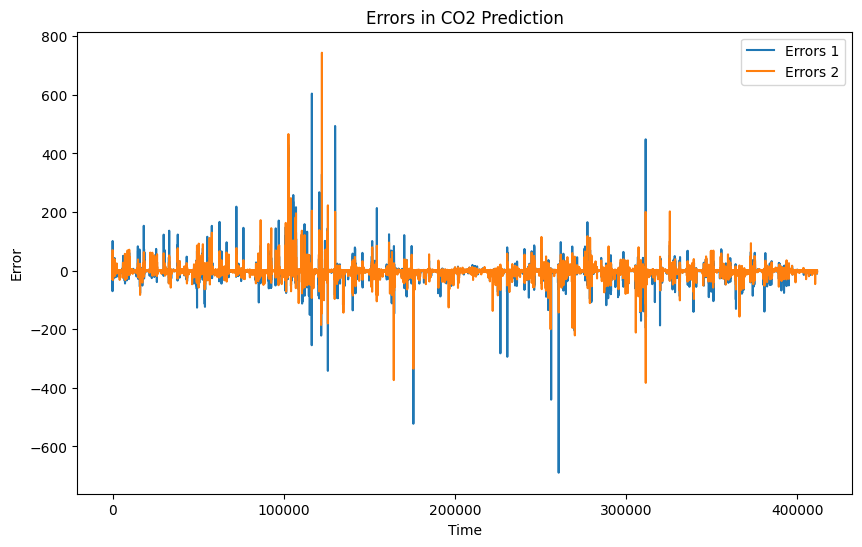

In [ ]:
import matplotlib.pyplot as plt

# Замените столбцы на ваши данные
predicted_data_1 = result_df['Extra_Trees_Predictions_all_features']  # Первый столбец прогноза
predicted_data_2 = result_df['Random Forest_Prediction_selected_features']  # Второй столбец прогноза
real_data = result_df['co2']  # Оригинальная целевая переменная

# Расчет ошибок для двух предсказанных столбцов
errors_1 = real_data - predicted_data_1
errors_2 = real_data - predicted_data_2

plt.figure(figsize=(10, 6))

# График ошибок для первого спрогнозированного столбца
plt.plot(errors_1, label='Errors 1')

# График ошибок для второго спрогнозированного столбца
plt.plot(errors_2, label='Errors 2')

plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Errors in CO2 Prediction')
plt.legend()
plt.show()

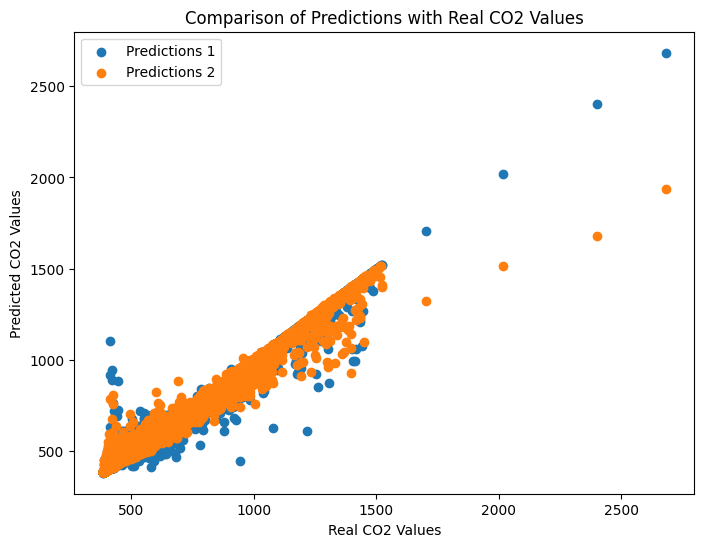

In [38]:
# Замените столбцы на ваши данные
predicted_data_1 = result_df['Extra_Trees_Predictions_all_features']  # Первый столбец прогноза
predicted_data_2 = result_df['Random Forest_Prediction_selected_features']  # Второй столбец прогноза
real_data = result_df['co2']  # Оригинальная целевая переменная

plt.figure(figsize=(8, 6))

# График сравнения первого спрогнозированного столбца с реальными данными
plt.scatter(real_data, predicted_data_1, label='Predictions 1')

# График сравнения второго спрогнозированного столбца с реальными данными
plt.scatter(real_data, predicted_data_2, label='Predictions 2')

plt.xlabel('Real CO2 Values')
plt.ylabel('Predicted CO2 Values')
plt.title('Comparison of Predictions with Real CO2 Values')
plt.legend()
plt.show()

Predicting for other rooms

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# Путь к вашему исходному файлу
input_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room01.csv'

# Загрузка данных
cleaned_data_room01 = pd.read_csv(input_file_path)

# Преобразование столбца 'devicetimestamp' в формат datetime
cleaned_data_room01['devicetimestamp'] = pd.to_datetime(cleaned_data_room01['devicetimestamp'])

# Определение признаков (X) и целевой переменной (y)
X = cleaned_data_room01.drop(['devicetimestamp', 'co2'], axis=1)
y = cleaned_data_room01['co2']

# Создание моделей
models = {
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Словарь для хранения ошибок каждой модели
errors = {}

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение моделей и оценка производительности на тестовом наборе
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки на тестовом наборе
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем ошибки для текущей модели
    errors[model_name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    }

# Вывод ошибок всех моделей
errors_df = pd.DataFrame(errors)
print(errors_df)

# Находим модель с наименьшей MSE
best_model_name = min(errors, key=lambda k: errors[k]['MSE'])

# Прогнозирование с использованием лучшей модели на всем наборе данных
best_model = models[best_model_name]
best_model.fit(X, y) # Обучаем на всем наборе данных

# Предсказание с лучшей моделью для всего набора данных
full_predictions = best_model.predict(X)
cleaned_data_room01[f'{best_model_name}_Prediction_selected_features'] = full_predictions

# Создание массива с нужными столбцами
result_df = cleaned_data_room01[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room01['Extra_Trees_Predictions']
result_df

      Random Forest  Extra Trees      XGBoost
R2         0.975910     0.962018     0.873409
MSE      205.113201   323.391871  1077.841867
MAE        4.447430     6.159710    18.328411
MAPE       0.007990     0.010733     0.036027


<ipython-input-24-59c5a208f6cf>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room01['Extra_Trees_Predictions']


,devicetimestamp,co2,Random Forest_Prediction_selected_features,Extra_Trees_Predictions_all_features
0,2019-01-11 13:39:00,538.0,552.74,538.000
1,2019-01-11 13:40:00,538.0,548.72,538.000
2,2019-01-11 13:41:00,539.0,553.59,539.000
3,2019-01-11 13:42:00,541.0,550.39,541.000
4,2019-01-11 13:43:00,541.0,558.39,541.000
...,...,...,...,...
442538,2019-12-31 21:55:00,397.0,397.13,397.000
442539,2019-12-31 21:56:00,396.0,397.00,397.155
442540,2019-12-31 21:57:00,398.0,398.04,397.440
442541,2019-12-31 21:58:00,399.0,400.86,397.475


In [30]:
result_df = cleaned_data_room01[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
# Добавляем столбец Extra_Trees_Predictions из массива all_features_room00 к result_df
result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room01['Extra_Trees_Predictions']
# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/Final results/Final results Room01.csv'
# Сохранение нового файла CSV
result_df.to_csv(output_file_path, index=False)
result_df

<ipython-input-30-e24ce376d39c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room01['Extra_Trees_Predictions']


,devicetimestamp,co2,Random Forest_Prediction_selected_features,Extra_Trees_Predictions_all_features
0,2019-01-11 13:39:00,538.0,552.74,538.000
1,2019-01-11 13:40:00,538.0,548.72,538.000
2,2019-01-11 13:41:00,539.0,553.59,539.000
3,2019-01-11 13:42:00,541.0,550.39,541.000
4,2019-01-11 13:43:00,541.0,558.39,541.000
...,...,...,...,...
442538,2019-12-31 21:55:00,397.0,397.13,397.000
442539,2019-12-31 21:56:00,396.0,397.00,397.155
442540,2019-12-31 21:57:00,398.0,398.04,397.440
442541,2019-12-31 21:58:00,399.0,400.86,397.475


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# Путь к вашему исходному файлу
input_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room02.csv'

# Загрузка данных
cleaned_data_room02 = pd.read_csv(input_file_path)

# Преобразование столбца 'devicetimestamp' в формат datetime
cleaned_data_room02['devicetimestamp'] = pd.to_datetime(cleaned_data_room02['devicetimestamp'])

# Определение признаков (X) и целевой переменной (y)
X = cleaned_data_room02.drop(['devicetimestamp', 'co2'], axis=1)
y = cleaned_data_room02['co2']

# Создание моделей
models = {
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Словарь для хранения ошибок каждой модели
errors = {}

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение моделей и оценка производительности на тестовом наборе
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки на тестовом наборе
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем ошибки для текущей модели
    errors[model_name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    }

# Вывод ошибок всех моделей
errors_df = pd.DataFrame(errors)
print(errors_df)

# Находим модель с наименьшей MSE
best_model_name = min(errors, key=lambda k: errors[k]['MSE'])

# Прогнозирование с использованием лучшей модели на всем наборе данных
best_model = models[best_model_name]
best_model.fit(X, y) # Обучаем на всем наборе данных

# Предсказание с лучшей моделью для всего набора данных
full_predictions = best_model.predict(X)
cleaned_data_room02[f'{best_model_name}_Prediction_selected_features'] = full_predictions

# Создание массива с нужными столбцами
result_df = cleaned_data_room02[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room02['Extra_Trees_Predictions']
# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/Final results/Final results Room02.csv'
# Сохранение нового файла CSV
result_df.to_csv(output_file_path, index=False)
result_df

      Random Forest  Extra Trees     XGBoost
R2         0.973514     0.964188    0.894504
MSE      118.888826   160.752358  473.552346
MAE        3.397445     4.311572   12.285781
MAPE       0.006519     0.008130    0.025447


<ipython-input-31-df34e24b28a8>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room02['Extra_Trees_Predictions']


,devicetimestamp,co2,Random Forest_Prediction_selected_features,Extra_Trees_Predictions_all_features
0,2019-01-09 10:07:00,752.0,691.680000,752.000
1,2019-01-09 10:08:00,747.0,708.450000,747.000
2,2019-01-09 10:09:00,740.0,687.870000,579.415
3,2019-01-09 10:10:00,728.0,696.410000,728.000
4,2019-01-09 10:11:00,719.0,674.437500,719.000
...,...,...,...,...
488618,2019-12-31 21:55:00,398.0,397.977619,399.270
488619,2019-12-31 21:56:00,397.0,398.251786,398.760
488620,2019-12-31 21:57:00,398.0,398.458333,400.280
488621,2019-12-31 21:58:00,398.0,398.773333,398.000


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# Путь к вашему исходному файлу
input_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room03.csv'

# Загрузка данных
cleaned_data_room03 = pd.read_csv(input_file_path)

# Преобразование столбца 'devicetimestamp' в формат datetime
cleaned_data_room03['devicetimestamp'] = pd.to_datetime(cleaned_data_room03['devicetimestamp'])

# Определение признаков (X) и целевой переменной (y)
X = cleaned_data_room03.drop(['devicetimestamp', 'co2'], axis=1)
y = cleaned_data_room03['co2']

# Создание моделей
models = {
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Словарь для хранения ошибок каждой модели
errors = {}

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение моделей и оценка производительности на тестовом наборе
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки на тестовом наборе
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем ошибки для текущей модели
    errors[model_name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    }

# Вывод ошибок всех моделей
errors_df = pd.DataFrame(errors)
print(errors_df)

# Находим модель с наименьшей MSE
best_model_name = min(errors, key=lambda k: errors[k]['MSE'])

# Прогнозирование с использованием лучшей модели на всем наборе данных
best_model = models[best_model_name]
best_model.fit(X, y) # Обучаем на всем наборе данных

# Предсказание с лучшей моделью для всего набора данных
full_predictions = best_model.predict(X)
cleaned_data_room03[f'{best_model_name}_Prediction_selected_features'] = full_predictions

# Создание массива с нужными столбцами
result_df = cleaned_data_room03[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room03['Extra_Trees_Predictions']
# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/Final results/Final results Room03.csv'
# Сохранение нового файла CSV
result_df.to_csv(output_file_path, index=False)
result_df

      Random Forest  Extra Trees      XGBoost
R2         0.983000     0.977818     0.878045
MSE      178.620928   233.072799  1281.431531
MAE        3.222075     4.077624    18.315960
MAPE       0.005807     0.007179     0.035685


<ipython-input-32-b500d657187a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room03['Extra_Trees_Predictions']


,devicetimestamp,co2,Random Forest_Prediction_selected_features,Extra_Trees_Predictions_all_features
0,2019-01-01 00:03:00,402.0,402.540,402.000
1,2019-01-01 00:04:00,402.0,402.305,402.000
2,2019-01-01 00:05:00,404.0,403.280,402.395
3,2019-01-01 00:06:00,403.0,408.495,403.000
4,2019-01-01 00:07:00,402.0,402.150,402.000
...,...,...,...,...
508909,2019-12-31 21:55:00,399.0,398.920,399.000
508910,2019-12-31 21:56:00,400.0,399.940,400.000
508911,2019-12-31 21:57:00,400.0,399.940,399.900
508912,2019-12-31 21:58:00,400.0,399.980,400.000


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# Путь к вашему исходному файлу
input_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room04.csv'

# Загрузка данных
cleaned_data_room04 = pd.read_csv(input_file_path)

# Преобразование столбца 'devicetimestamp' в формат datetime
cleaned_data_room04['devicetimestamp'] = pd.to_datetime(cleaned_data_room04['devicetimestamp'])

# Определение признаков (X) и целевой переменной (y)
X = cleaned_data_room04.drop(['devicetimestamp', 'co2'], axis=1)
y = cleaned_data_room04['co2']

# Создание моделей
models = {
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Словарь для хранения ошибок каждой модели
errors = {}

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение моделей и оценка производительности на тестовом наборе
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки на тестовом наборе
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем ошибки для текущей модели
    errors[model_name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    }

# Вывод ошибок всех моделей
errors_df = pd.DataFrame(errors)
print(errors_df)

# Находим модель с наименьшей MSE
best_model_name = min(errors, key=lambda k: errors[k]['MSE'])

# Прогнозирование с использованием лучшей модели на всем наборе данных
best_model = models[best_model_name]
best_model.fit(X, y) # Обучаем на всем наборе данных

# Предсказание с лучшей моделью для всего набора данных
full_predictions = best_model.predict(X)
cleaned_data_room04[f'{best_model_name}_Prediction_selected_features'] = full_predictions

# Создание массива с нужными столбцами
result_df = cleaned_data_room04[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room04['Extra_Trees_Predictions']
# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/Final results/Final results Room04.csv'
# Сохранение нового файла CSV
result_df.to_csv(output_file_path, index=False)
result_df

      Random Forest  Extra Trees     XGBoost
R2         0.952800     0.937194    0.869651
MSE      127.848538   170.119201  353.071517
MAE        2.624740     3.107335    8.783937
MAPE       0.005285     0.006139    0.019010


<ipython-input-33-9d687d01b701>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room04['Extra_Trees_Predictions']


,devicetimestamp,co2,Random Forest_Prediction_selected_features,Extra_Trees_Predictions_all_features
0,2019-02-08 09:12:00,542.0,537.400,542.00
1,2019-02-08 09:13:00,533.0,542.560,533.00
2,2019-02-08 09:14:00,530.0,549.520,530.00
3,2019-02-08 09:15:00,523.5,522.020,523.50
4,2019-02-08 09:16:00,509.0,514.145,509.00
...,...,...,...,...
436366,2019-12-31 21:55:00,405.0,404.810,405.00
436367,2019-12-31 21:56:00,405.0,404.930,405.00
436368,2019-12-31 21:57:00,405.0,404.990,405.00
436369,2019-12-31 21:58:00,405.0,404.990,405.00


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# Путь к вашему исходному файлу
input_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room05.csv'

# Загрузка данных
cleaned_data_room05 = pd.read_csv(input_file_path)

# Преобразование столбца 'devicetimestamp' в формат datetime
cleaned_data_room05['devicetimestamp'] = pd.to_datetime(cleaned_data_room05['devicetimestamp'])

# Определение признаков (X) и целевой переменной (y)
X = cleaned_data_room05.drop(['devicetimestamp', 'co2'], axis=1)
y = cleaned_data_room05['co2']

# Создание моделей
models = {
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Словарь для хранения ошибок каждой модели
errors = {}

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение моделей и оценка производительности на тестовом наборе
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки на тестовом наборе
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем ошибки для текущей модели
    errors[model_name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    }

# Вывод ошибок всех моделей
errors_df = pd.DataFrame(errors)
print(errors_df)

# Находим модель с наименьшей MSE
best_model_name = min(errors, key=lambda k: errors[k]['MSE'])

# Прогнозирование с использованием лучшей модели на всем наборе данных
best_model = models[best_model_name]
best_model.fit(X, y) # Обучаем на всем наборе данных

# Предсказание с лучшей моделью для всего набора данных
full_predictions = best_model.predict(X)
cleaned_data_room05[f'{best_model_name}_Prediction_selected_features'] = full_predictions

# Создание массива с нужными столбцами
result_df = cleaned_data_room05[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room05['Extra_Trees_Predictions']
# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/Final results/Final results Room05.csv'
# Сохранение нового файла CSV
result_df.to_csv(output_file_path, index=False)
result_df

      Random Forest  Extra Trees     XGBoost
R2         0.958210     0.944218    0.863573
MSE       65.680497    87.672405  214.422182
MAE        2.766780     3.352046    8.909296
MAPE       0.005890     0.007064    0.019810


<ipython-input-34-08646808adf3>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room05['Extra_Trees_Predictions']


,devicetimestamp,co2,Random Forest_Prediction_selected_features,Extra_Trees_Predictions_all_features
0,2019-01-07 13:26:00,466.0,469.355,466.000
1,2019-01-07 13:27:00,466.0,470.665,466.000
2,2019-01-07 13:28:00,465.0,463.610,467.215
3,2019-01-07 13:29:00,463.0,466.010,463.000
4,2019-01-07 13:30:00,465.0,468.105,465.000
...,...,...,...,...
484049,2019-12-31 21:55:00,400.0,400.070,400.000
484050,2019-12-31 21:56:00,400.0,400.000,400.000
484051,2019-12-31 21:57:00,400.0,399.910,399.830
484052,2019-12-31 21:58:00,400.0,399.990,400.000


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

# Путь к вашему исходному файлу
input_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/After cleaning features/Cleaned features Room06.csv'

# Загрузка данных
cleaned_data_room06 = pd.read_csv(input_file_path)

# Преобразование столбца 'devicetimestamp' в формат datetime
cleaned_data_room06['devicetimestamp'] = pd.to_datetime(cleaned_data_room06['devicetimestamp'])

# Определение признаков (X) и целевой переменной (y)
X = cleaned_data_room06.drop(['devicetimestamp', 'co2'], axis=1)
y = cleaned_data_room06['co2']

# Создание моделей
models = {
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

# Словарь для хранения ошибок каждой модели
errors = {}

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение моделей и оценка производительности на тестовом наборе
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Рассчитываем метрики оценки на тестовом наборе
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Сохраняем ошибки для текущей модели
    errors[model_name] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape
    }

# Вывод ошибок всех моделей
errors_df = pd.DataFrame(errors)
print(errors_df)

# Находим модель с наименьшей MSE
best_model_name = min(errors, key=lambda k: errors[k]['MSE'])

# Прогнозирование с использованием лучшей модели на всем наборе данных
best_model = models[best_model_name]
best_model.fit(X, y) # Обучаем на всем наборе данных

# Предсказание с лучшей моделью для всего набора данных
full_predictions = best_model.predict(X)
cleaned_data_room06[f'{best_model_name}_Prediction_selected_features'] = full_predictions

# Создание массива с нужными столбцами
result_df = cleaned_data_room06[['devicetimestamp', 'co2', f'{best_model_name}_Prediction_selected_features']]
result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room06['Extra_Trees_Predictions']
# Путь для сохранения нового файла
output_file_path = '/content/drive/MyDrive/Buildings project3/Cleaned data/Final results/Final results Room06.csv'
# Сохранение нового файла CSV
result_df.to_csv(output_file_path, index=False)
result_df

      Random Forest  Extra Trees     XGBoost
R2         0.931977     0.910317    0.843902
MSE       95.001856   125.252198  218.008129
MAE        3.092647     3.577184    8.779322
MAPE       0.006438     0.007380    0.019558


<ipython-input-35-64804110469f>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'Extra_Trees_Predictions_all_features'] = all_features_room06['Extra_Trees_Predictions']


,devicetimestamp,co2,Random Forest_Prediction_selected_features,Extra_Trees_Predictions_all_features
0,2019-01-23 09:12:00,580.0,592.87,580.00
1,2019-01-23 09:13:00,583.0,596.80,583.00
2,2019-01-23 09:14:00,589.0,595.25,589.00
3,2019-01-23 09:15:00,590.0,602.11,590.00
4,2019-01-23 09:16:00,594.0,599.33,594.00
...,...,...,...,...
457941,2019-12-31 21:55:00,396.0,395.56,395.17
457942,2019-12-31 21:56:00,396.0,396.08,396.00
457943,2019-12-31 21:57:00,395.0,395.26,395.00
457944,2019-12-31 21:58:00,395.0,395.97,395.00
